In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline

## Priprema podataka

In [44]:
data=np.load('CompleteDataSet_validation_tuples/CompleteDataSet_validation_tuples.npy',allow_pickle=True)

In [45]:
#Svi prisutni labeli
np.unique(data[:,1])

array(['%', '*', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', '[', ']'], dtype=object)

In [57]:
X=data[:,0]
y=data[:,1]
#'%' zapravo označava '/' pa zamijenimo label
y=np.where(y!='%',y,'/')

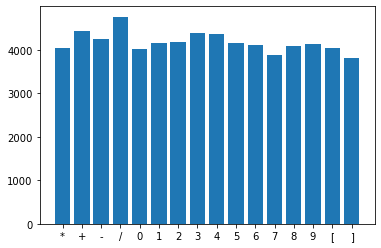

In [59]:
unique, indices, counts = np.unique(y, return_index=True ,return_counts=True)
fig, ax = plt.subplots()
ax.bar(unique,counts)
plt.show()

In [60]:
data.shape

(66777, 2)

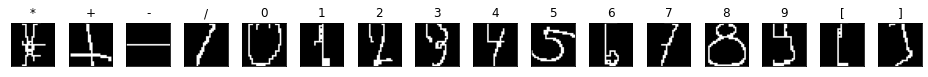

In [61]:
characters = X[indices]
plt.figure(figsize=(13, 2))
for i in range(len(characters)):
    plt.subplot(1, len(characters), i + 1)
    plt.imshow(characters[i], cmap='gray', vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.title(y[indices][i])
plt.tight_layout()

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

X_train = np.stack(X_train, axis=0)
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))

X_test = np.stack(X_test, axis=0)
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

y_train=pd.get_dummies(y_train).values
y_test=pd.get_dummies(y_test).values

X_train=X_train.astype('float32')
X_test=X_test.astype('float32')

## Kreiranje CNN modela

In [63]:
def create_model(learning_rate):
    model=Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(unique.shape[0], activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
    return model

In [64]:
def train_model(model, X_train, y_train, epochs, batch_size, validation):
    callback = EarlyStopping(monitor='val_loss', mode='min')
    history=model.fit(X_train, y_train, batch_size=batch_size,
                      epochs=epochs, shuffle=True, callbacks=[callback], 
                      validation_split=validation)
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

In [65]:
def plot_metrics(epochs, hist, metrics, title):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title(title)

    for m in metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()

In [72]:
learning_rate=0.001
epochs=10
validation=0.25
batch_size=128

Train on 40065 samples, validate on 13356 samples
Epoch 1/10
40065/40065 [==============================] - 24s 594us/sample - loss: 0.8445 - accuracy: 0.7341 - val_loss: 0.3538 - val_accuracy: 0.8905
Epoch 2/10
40065/40065 [==============================] - 23s 565us/sample - loss: 0.3663 - accuracy: 0.8847 - val_loss: 0.2334 - val_accuracy: 0.9268
Epoch 3/10
40065/40065 [==============================] - 24s 609us/sample - loss: 0.2790 - accuracy: 0.9118 - val_loss: 0.2064 - val_accuracy: 0.9346
Epoch 4/10
40065/40065 [==============================] - 24s 591us/sample - loss: 0.2379 - accuracy: 0.9241 - val_loss: 0.1708 - val_accuracy: 0.9458
Epoch 5/10
40065/40065 [==============================] - 24s 611us/sample - loss: 0.2037 - accuracy: 0.9334 - val_loss: 0.1637 - val_accuracy: 0.9473
Epoch 6/10
40065/40065 [==============================] - 23s 576us/sample - loss: 0.1836 - accuracy: 0.9410 - val_loss: 0.1578 - val_accuracy: 0.9485
Epoch 7/10
40065/40065 [====================

[0.1258727865693597, 0.9589698]

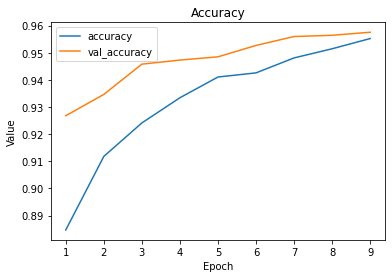

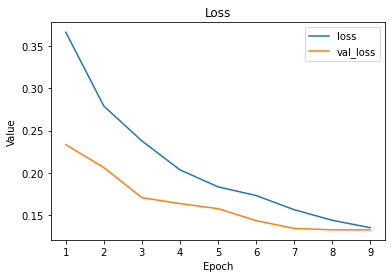

In [73]:
model=create_model(learning_rate)
epochs, hist = train_model(model, X_train, y_train, 
                           epochs, batch_size, validation)
plot_metrics(epochs, hist, ['accuracy','val_accuracy'], "Accuracy")
plot_metrics(epochs, hist, ['loss','val_loss'], "Loss")
model.evaluate(x = X_test, y = y_test, batch_size=batch_size, verbose=0)

## Spremanje modela

In [70]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1600)            

In [71]:
model.save('models/model_1.h5')

## Predikcije

In [74]:
#Kodiramo simbole brojevima
codes={i:unique[i] for i in range(len(unique))}
codes

{0: '*',
 1: '+',
 2: '-',
 3: '/',
 4: '0',
 5: '1',
 6: '2',
 7: '3',
 8: '4',
 9: '5',
 10: '6',
 11: '7',
 12: '8',
 13: '9',
 14: '[',
 15: ']'}

In [75]:
#Spremamo kodove
with open("codes", "wb") as fp:   #Pickling
    pickle.dump(codes, fp)

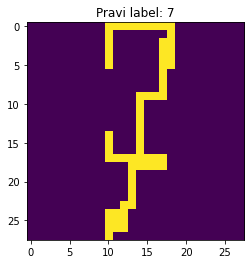

In [37]:
plt.imshow(X_test[3])
#label
plt.title(f'Pravi label: {codes[np.argmax(y_test[3])]}')
plt.show()

In [38]:
prediction = model.predict(X_train[np.newaxis,3])
print(f'Predikcija modela je {codes[np.argmax(prediction)]}')

Predikcija modela je 7


In [42]:
X_train[3].shape

(28, 28, 1)

In [43]:
X_train[np.newaxis,3].shape

(1, 28, 28, 1)